  4%|▍         | 221/5000 [00:00<00:15, 308.68it/s]


Early stopping


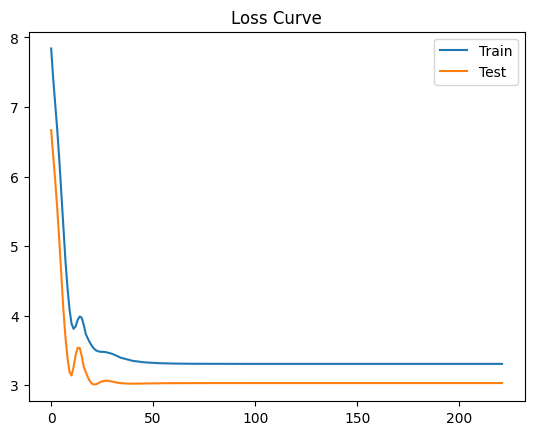

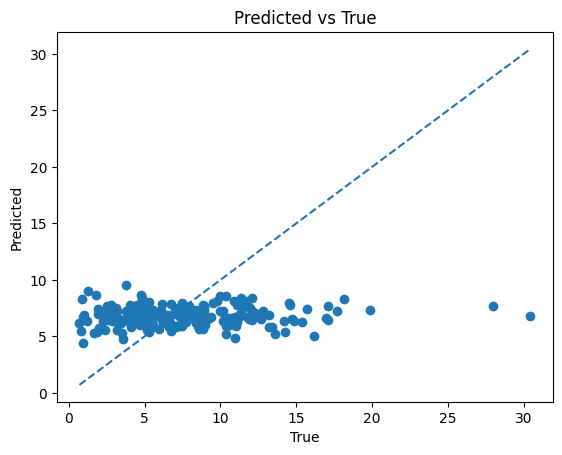

Best Test Loss: 3.0108067989349365


In [16]:
# ==========================================
# BASIC FULLY CONNECTED NN REGRESSION
# ==========================================

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import copy

# -----------------------------
# Load Data
# -----------------------------
df1 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/simulated_abundance_switch.csv")
df2 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/production_output_summary.csv")

df1.columns = df1.columns.str.strip().str.lower()
df2.columns = df2.columns.str.strip().str.lower()

comm_col_1 = "community" if "community" in df1.columns else "comm_name"
comm_col_2 = "community" if "community" in df2.columns else "comm_name"

time_zero_df = df1[df1["time"] == 0].copy()

merged_df = time_zero_df.merge(
    df2[[comm_col_2, "output"]],
    left_on=comm_col_1,
    right_on=comm_col_2,
    how="left"
).dropna(subset=["output"])

sp_columns = sorted(
    [col for col in merged_df.columns if col.startswith("sp")],
    key=lambda x: int(x[2:])
)

X = merged_df[sp_columns].values
y = merged_df["output"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

input_size = X_train.shape[1]

# -----------------------------
# Model
# -----------------------------
class BasicNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

model = BasicNN(input_size)

criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# -----------------------------
# Training
# -----------------------------
epochs = 5000
patience = 200
best_loss = float("inf")
counter = 0
best_state = copy.deepcopy(model.state_dict())

train_losses, test_losses = [], []

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train)
    train_loss = criterion(train_pred, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    scheduler.step(test_loss)

    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        best_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping")
        break

model.load_state_dict(best_state)

# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.title("Loss Curve")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

true_values = y_test.numpy()

plt.figure()
plt.scatter(true_values, predictions)
min_val = min(true_values.min(), predictions.min())
max_val = max(true_values.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True")
plt.show()

print("Best Test Loss:", best_loss)

  5%|▌         | 256/5000 [00:02<00:40, 116.52it/s]


Early stopping


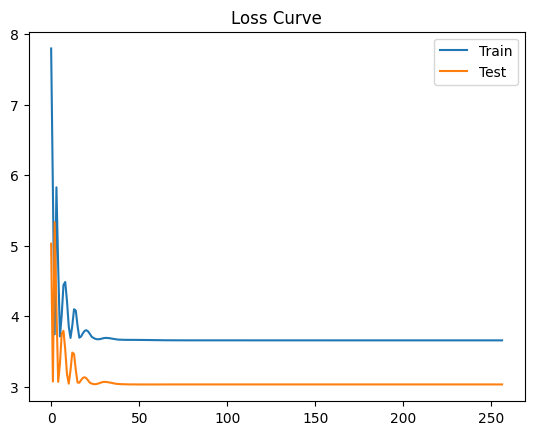

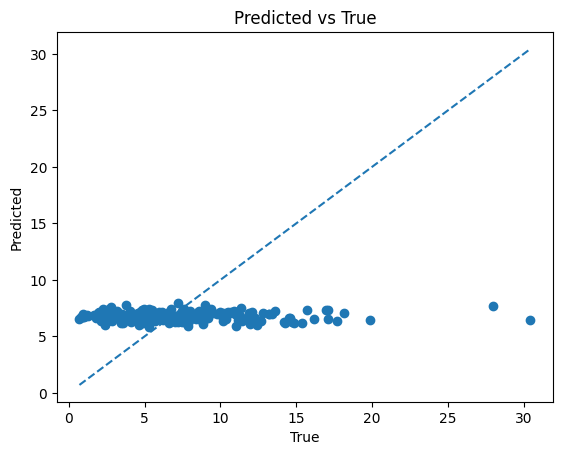

Best Test Loss: 3.0296404361724854


In [14]:
# ==========================================
# PURE CNN REGRESSION
# ==========================================

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import copy

# -----------------------------
# Load Data (Same)
# -----------------------------
df1 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/simulated_abundance_switch.csv")
df2 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/production_output_summary.csv")

df1.columns = df1.columns.str.strip().str.lower()
df2.columns = df2.columns.str.strip().str.lower()

comm_col_1 = "community" if "community" in df1.columns else "comm_name"
comm_col_2 = "community" if "community" in df2.columns else "comm_name"

time_zero_df = df1[df1["time"] == 0].copy()

merged_df = time_zero_df.merge(
    df2[[comm_col_2, "output"]],
    left_on=comm_col_1,
    right_on=comm_col_2,
    how="left"
).dropna(subset=["output"])

sp_columns = sorted(
    [col for col in merged_df.columns if col.startswith("sp")],
    key=lambda x: int(x[2:])
)

X = merged_df[sp_columns].values
y = merged_df["output"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

input_length = X_train.shape[2]

# -----------------------------
# Model
# -----------------------------
class PureCNN(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=2),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            dummy = self.conv(dummy)
            self.flat_size = dummy.numel()

        self.fc = nn.Linear(self.flat_size, 1)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = PureCNN(input_length)

criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# -----------------------------
# Training
# -----------------------------
epochs = 5000
patience = 200
best_loss = float("inf")
counter = 0
best_state = copy.deepcopy(model.state_dict())

train_losses, test_losses = [], []

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train)
    train_loss = criterion(train_pred, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    scheduler.step(test_loss)

    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        best_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping")
        break

model.load_state_dict(best_state)

# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.title("Loss Curve")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

true_values = y_test.numpy()

plt.figure()
plt.scatter(true_values, predictions)
min_val = min(true_values.min(), predictions.min())
max_val = max(true_values.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True")
plt.show()

print("Best Test Loss:", best_loss)

  6%|▌         | 276/5000 [00:04<01:16, 61.38it/s]


Early stopping


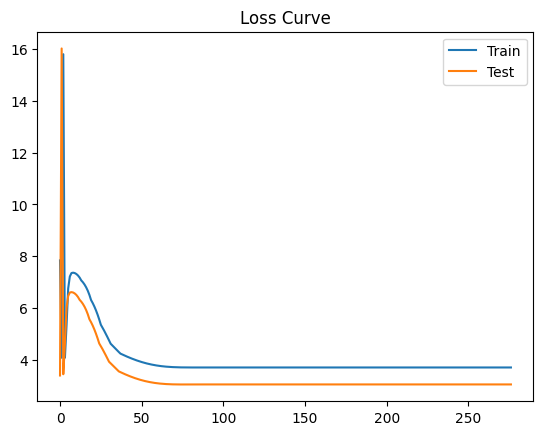

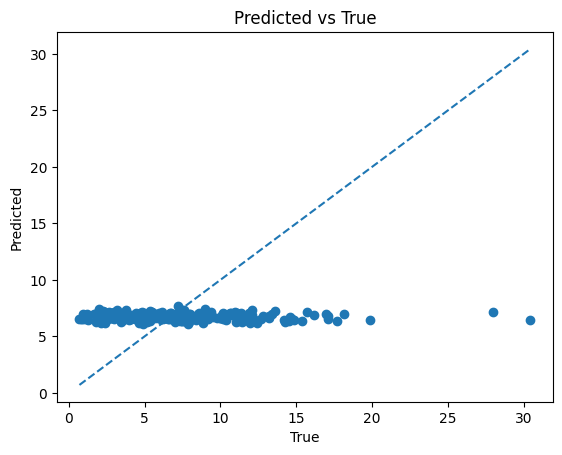

Best Test Loss: 3.035548210144043


In [15]:
# ==========================================
# HYBRID CNN + MLP REGRESSION
# ==========================================

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import copy

# -----------------------------
# Data Loading (Same)
# -----------------------------
df1 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/simulated_abundance_switch.csv")
df2 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/production_output_summary.csv")

df1.columns = df1.columns.str.strip().str.lower()
df2.columns = df2.columns.str.strip().str.lower()

comm_col_1 = "community" if "community" in df1.columns else "comm_name"
comm_col_2 = "community" if "community" in df2.columns else "comm_name"

time_zero_df = df1[df1["time"] == 0].copy()

merged_df = time_zero_df.merge(
    df2[[comm_col_2, "output"]],
    left_on=comm_col_1,
    right_on=comm_col_2,
    how="left"
).dropna(subset=["output"])

sp_columns = sorted(
    [col for col in merged_df.columns if col.startswith("sp")],
    key=lambda x: int(x[2:])
)

X = merged_df[sp_columns].values
y = merged_df["output"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

input_length = X_train.shape[2]

# -----------------------------
# Model
# -----------------------------
class HybridModel(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=2),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            dummy = self.conv(dummy)
            self.flat_size = dummy.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = HybridModel(input_length)

criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# -----------------------------
# Training
# -----------------------------
epochs = 5000
patience = 200
best_loss = float("inf")
counter = 0
best_state = copy.deepcopy(model.state_dict())

train_losses, test_losses = [], []

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train)
    train_loss = criterion(train_pred, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    scheduler.step(test_loss)

    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        best_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping")
        break

model.load_state_dict(best_state)

# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.title("Loss Curve")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

true_values = y_test.numpy()

plt.figure()
plt.scatter(true_values, predictions)
min_val = min(true_values.min(), predictions.min())
max_val = max(true_values.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True")
plt.show()

print("Best Test Loss:", best_loss)


Training Big MLP...



  7%|▋         | 352/5000 [00:12<02:45, 28.14it/s]


Early stopping


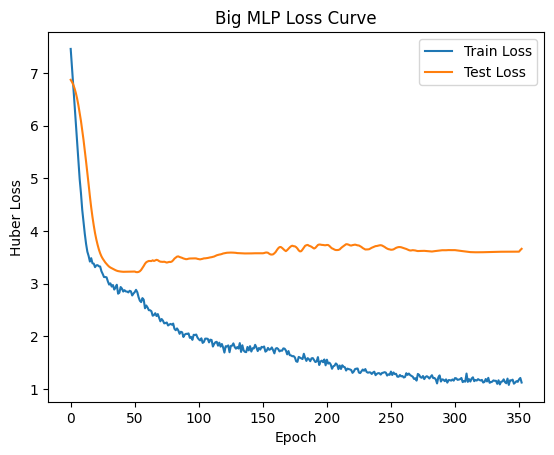

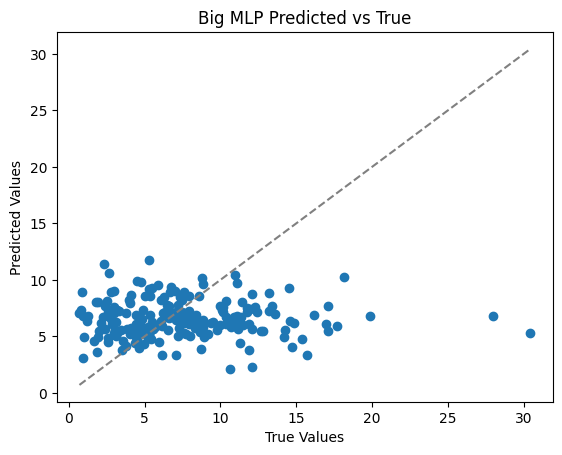

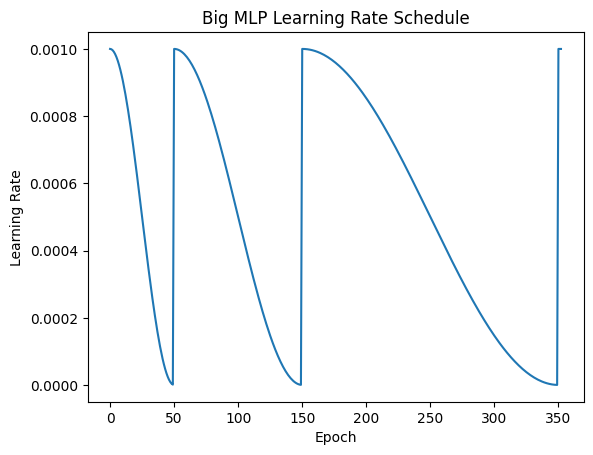


Training Big CNN...



  6%|▋         | 321/5000 [02:29<36:24,  2.14it/s]  

Early stopping


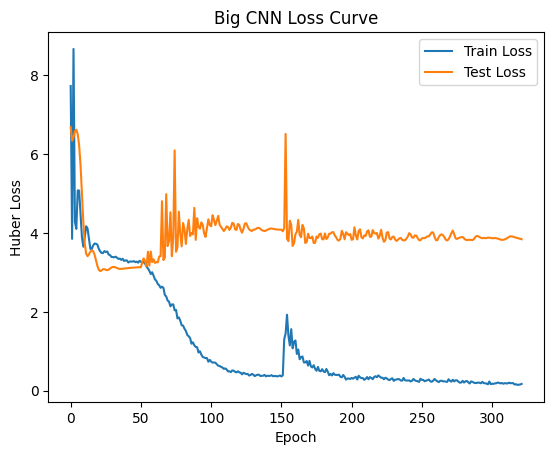

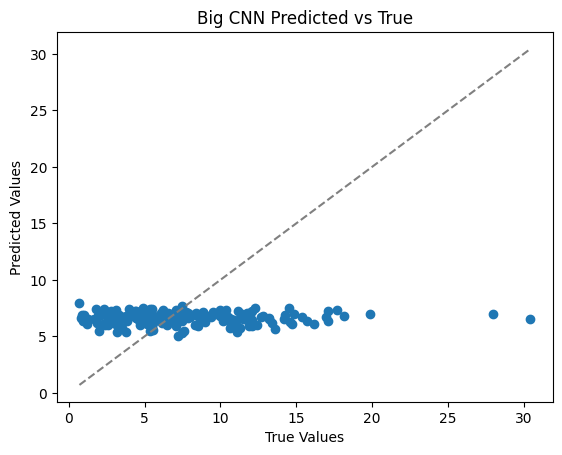

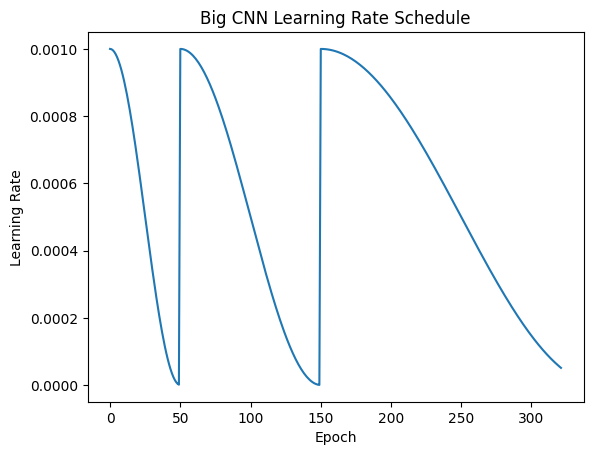


Training Big Hybrid...



  6%|▋         | 322/5000 [02:43<39:33,  1.97it/s]

Early stopping


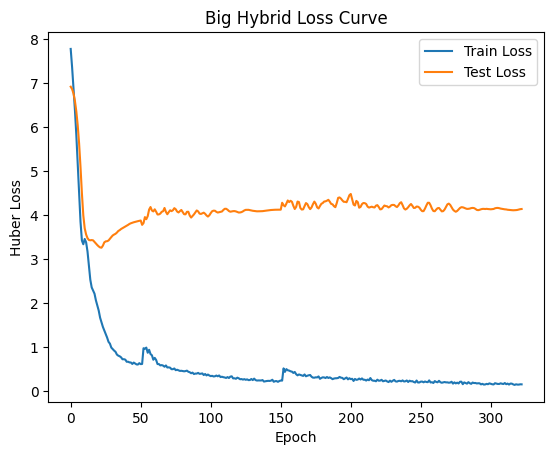

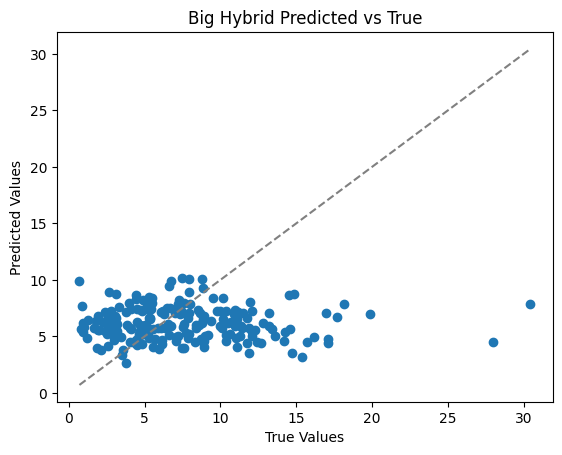

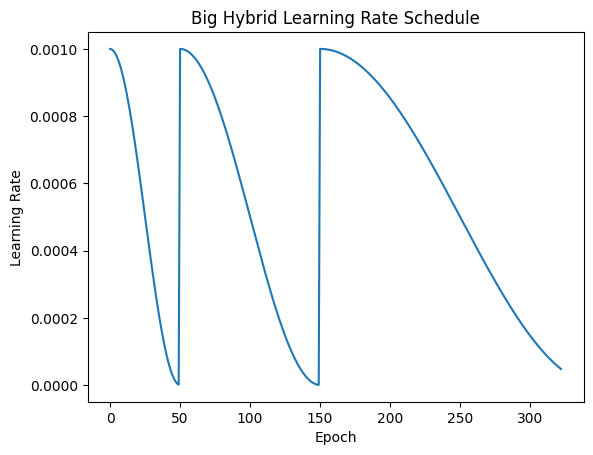


============= FINAL MODEL COMPARISON =============

Big MLP
  Best Test Huber Loss: 3.217096
  R² Score: -0.188475
  MAE: 3.675987
--------------------------------------------------
Big CNN
  Best Test Huber Loss: 3.034556
  R² Score: -0.048595
  MAE: 3.500118
--------------------------------------------------
Big Hybrid
  Best Test Huber Loss: 3.260387
  R² Score: -0.210699
  MAE: 3.723475
--------------------------------------------------


In [19]:
# ==========================================
# LARGE MODEL COMPARISON
# Big MLP vs Big CNN vs Big Hybrid
# With:
# - CosineAnnealingWarmRestarts
# - Early Stopping
# - Loss Curves
# - Predicted vs True Plots
# - R² and MAE Metrics
# ==========================================

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm
import copy
import numpy as np

# -----------------------------
# Load Data
# -----------------------------
df1 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/simulated_abundance_switch.csv")
df2 = pd.read_csv("C:/Users/josep/Downloads/Python 3.14.2/AI and Biocomputing/Project/production_output_summary.csv")

df1.columns = df1.columns.str.strip().str.lower()
df2.columns = df2.columns.str.strip().str.lower()

comm_col_1 = "community" if "community" in df1.columns else "comm_name"
comm_col_2 = "community" if "community" in df2.columns else "comm_name"

time_zero_df = df1[df1["time"] == 0].copy()

merged_df = time_zero_df.merge(
    df2[[comm_col_2, "output"]],
    left_on=comm_col_1,
    right_on=comm_col_2,
    how="left"
).dropna(subset=["output"])

sp_columns = sorted(
    [col for col in merged_df.columns if col.startswith("sp")],
    key=lambda x: int(x[2:])
)

X = merged_df[sp_columns].values
y = merged_df["output"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_nn = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_nn = torch.tensor(X_test_scaled, dtype=torch.float32)

X_train_cnn = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
X_test_cnn = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

input_size = X_train_nn.shape[1]
input_length = X_train_cnn.shape[2]

# ==========================================
# LARGE MODELS
# ==========================================

class BigMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)


class BigCNN(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            dummy = self.conv(dummy)
            self.flat = dummy.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.flat, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


class BigHybrid(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            dummy = self.conv(dummy)
            self.flat = dummy.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.flat, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# ==========================================
# TRAINING FUNCTION
# ==========================================

def train_model(model, X_train, X_test, y_train, y_test, name):

    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=50,
        T_mult=2,
        eta_min=1e-6
    )

    epochs = 5000
    patience = 300
    best_loss = float("inf")
    counter = 0
    best_state = copy.deepcopy(model.state_dict())

    train_losses, test_losses, lr_history = [], [], []

    print(f"\nTraining {name}...\n")

    for epoch in tqdm(range(epochs)):

        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)

        scheduler.step(epoch)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        lr_history.append(optimizer.param_groups[0]['lr'])

        if test_loss.item() < best_loss:
            best_loss = test_loss.item()
            best_state = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_state)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy()

    true_vals = y_test.numpy()
    r2 = r2_score(true_vals, preds)
    mae = mean_absolute_error(true_vals, preds)

    # -----------------------------
    # Plot Loss Curve
    # -----------------------------
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.title(f"{name} Loss Curve")
    plt.legend()
    plt.show()

    # -----------------------------
    # Plot Predictions vs True
    # -----------------------------
    plt.figure()
    plt.scatter(true_vals, preds)
    min_val = min(true_vals.min(), preds.min())
    max_val = max(true_vals.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="gray")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Predicted vs True")
    plt.show()

    # -----------------------------
    # Plot Learning Rate
    # -----------------------------
    plt.figure()
    plt.plot(lr_history)
    plt.title(f"{name} Learning Rate Schedule")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()

    return best_loss, r2, mae

# ==========================================
# RUN MODELS
# ==========================================

results = {}

results["Big MLP"] = train_model(
    BigMLP(input_size),
    X_train_nn, X_test_nn,
    y_train, y_test,
    "Big MLP"
)

results["Big CNN"] = train_model(
    BigCNN(input_length),
    X_train_cnn, X_test_cnn,
    y_train, y_test,
    "Big CNN"
)

results["Big Hybrid"] = train_model(
    BigHybrid(input_length),
    X_train_cnn, X_test_cnn,
    y_train, y_test,
    "Big Hybrid"
)

# ==========================================
# FINAL RESULTS
# ==========================================

print("\n============= FINAL MODEL COMPARISON =============\n")
for name, (loss, r2, mae) in results.items():
    print(f"{name}")
    print(f"  Best Test Huber Loss: {loss:.6f}")
    print(f"  R² Score: {r2:.6f}")
    print(f"  MAE: {mae:.6f}")
    print("--------------------------------------------------")